<table>
<tr>
<td width=15%><img src="../../img/UGA.png"></img></td>
<td><center><h1>Project n°3</h1></center></td>
<td width=15%><a href="https://team.inria.fr/tripop/team-members/" style="font-size: 16px; font-weight: bold">Florian Vincent</a> </td>
</tr>
</table>

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
import joblib
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report,roc_curve
from sklearn.ensemble import RandomForestClassifier
from src.functions import get_dataset

In [3]:
%load_ext autoreload
%autoreload 2

# Learning text classification

This project is heavily inspired from [Jigsaw's *Toxic Comments Classification* challenge](https://www.kaggle.com/competitions/jigsaw-toxic-comment-classification-challenge/overview) on kaggle.
To avoid copy-pastings of foreign code, it will guide you towards specific tools to test and use.

## Overview of the project

Take a look at the *zip*ed csv data files by unzipping them (`for name in $(ls *.zip); do unzip $name; done;`).

Every comment in the train set is classified with a label in `{"toxic", "severe_toxic", "obscene", "threat", "insult", "identity hate"}`.
You will need to train multiple kind of models to identify those comments, and you will test them against the test dataset.

# Part 1: Data exploration

In [4]:
# on commence par récupérer le jeu les jeux de données
# avec la fonctions get_dataset
X_train, y_train, X_test, y_test = get_dataset()

print("dimension de X_train set : " ,X_train.shape)
print("dimension de y_train set : " ,y_train.shape)
print("dimension de X_test set : " ,X_test.shape)
print("dimension de y_test set : " ,y_test.shape)

dimension de X_train set :  (159571,)
dimension de y_train set :  (159571, 6)
dimension de X_test set :  (63978,)
dimension de y_test set :  (63978, 6)


## Study the data

Representing textual data in an algebraic format (i.e. vectors & matrices) is not easy, but fortunately it has been quickly studied earlier in the lectures.

**Implement a word-vectorizer relying on simple counting for the textual data**

In [5]:
# Création d'une instance de CountVectorizer
vectorizer = CountVectorizer()

# Transformation des donnée de tout les comment_text en vecteurs
X = vectorizer.fit_transform(X_train)


# affichage de la dimension de la matrice résultante avec
# (n, p) n correspond au nombre de commentaire et p correspond au nombre de mot différents du fichier
print(X.shape)

(159571, 189775)


**Implement another vectorizing relying this time on the *tf-idf* metric. Use a pipeline if needed.**

In [11]:
# Création d'une instance de TfidfVectorizer
vectorizer = TfidfVectorizer()

# Transformation des donnée de tout les comment_text en vecteurs
X = vectorizer.fit_transform(X_train)
X_test_v = vectorizer.transform(X_test)

# affichage de la dimension de la matrice résultante avec
# (n, p) n correspond au nombre de commentaire et p correspond au nombre de mot différents du fichier
print(X.shape)
print(X_test_v.shape)

(159571, 189775)
(63978, 189775)


One may wish to take a deeper look in the database by using various techniques.

**Find a suitable dimension reduction technique to study the structure of the data. Display your findings with visual means (you can use `seaborn`).**

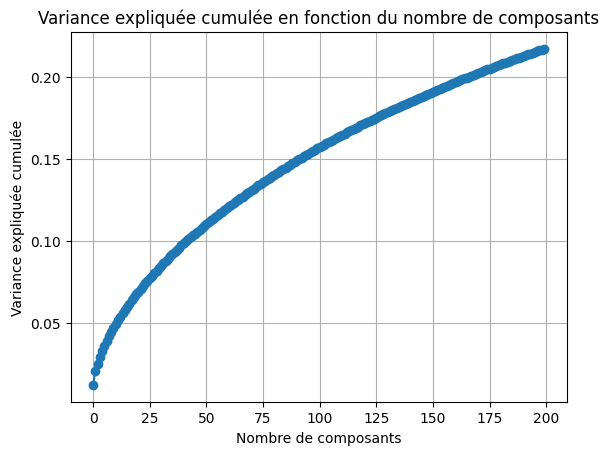

In [13]:
# Réduction de dimensionnalité avec TruncatedSVD
svd = TruncatedSVD(n_components=200)
X_svd = svd.fit_transform(X)
X_test_svd = svd.transform(X_test_v)

# Calcul de la variance expliquée cumulée
explained_variance_ratio_cumulative = np.cumsum(svd.explained_variance_ratio_)

# Tracé du graphique
plt.plot(explained_variance_ratio_cumulative, marker='o')
plt.title('Variance expliquée cumulée en fonction du nombre de composants')
plt.xlabel('Nombre de composants')
plt.ylabel('Variance expliquée cumulée')
plt.grid(True)
plt.show()

# on observe une très faible variance cumulé malgré 200 composants, cela s'explique
# par l'importante taille des données d'origine (189775)

## Make classification

We will study during this project a small amount of models.

### Logistic regression

The logistic regression is the most simple and naïve model one can use for classification specifically, but it can provide good insights on the baseline one may wish to achieve with more complex models.

**Implement a logistic classifier. Justify every parameter that you choose and how you chose it.**

In [14]:
model = MultiOutputClassifier(LogisticRegression())
model.fit(X_svd, y_train)
individual_estimators = model.estimators_

c:\Users\tomr2\Documents\Cours\Master SSD\ProgPy\toxic_comment_classification\env\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [15]:
# Initialize an array to store the probabilities for each output
y_pred_proba = []

# Get probabilities for each output separately
for estimator, target in zip(individual_estimators, y_train.columns):
    # Index the column using iloc to get the correct target
    y_pred_proba.append(estimator.predict_proba(X_svd)[:, 1])  # Assuming binary classification, adjust if needed

# Convert the list to a NumPy array
y_pred_proba = np.array(y_pred_proba).T

y_pred = model.predict(X_svd)
y_test_pred = model.predict(X_test_svd)

accuracy = accuracy_score(y_train, y_pred)
report = classification_report(y_train, y_pred,zero_division=1)
accuracy_test = accuracy_score(y_test, y_test_pred)
report_test = classification_report(y_test, y_test_pred,zero_division=1)

print(f"Accuracy: {accuracy}")
print(f"Classification Report:\n{report}")
print(f"Accuracy: {accuracy_test}")
print(f"Classification Report:\n{report_test}")

Accuracy: 0.9112182038089628
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.48      0.62     15294
           1       0.56      0.21      0.31      1595
           2       0.93      0.56      0.70      8449
           3       0.55      0.01      0.02       478
           4       0.79      0.41      0.54      7877
           5       0.48      0.05      0.10      1405

   micro avg       0.86      0.45      0.59     35098
   macro avg       0.70      0.29      0.38     35098
weighted avg       0.84      0.45      0.58     35098
 samples avg       0.99      0.93      0.93     35098

Accuracy: 0.9004657851136328
Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.49      0.58      6090
           1       0.30      0.22      0.25       367
           2       0.78      0.51      0.62      3691
           3       0.44      0.02      0.04       211
           4       0.70     

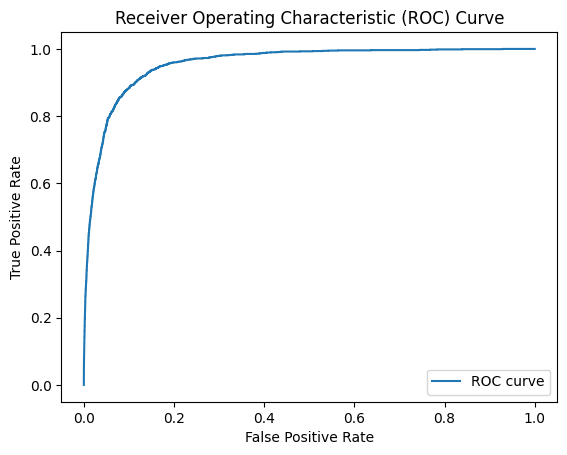

In [28]:
fpr, tpr, thresholds = roc_curve(y_train.iloc[:,5], y_pred_proba[:,5])   
plt.plot(fpr, tpr, label='ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

In [16]:
y_pred_proba[:,5]

array([0.0014417 , 0.00428817, 0.00142534, ..., 0.00844302, 0.00150628,
       0.00974471])

### SVM

The support vector machine used to be the SOTA method for many tasks before neural networks became more popular among data scientists.
Is has a lot of advantages as compared to logistic regression, as it is a kernel method of which the results are still relatively easy to interpret.

**Implement a SVM classifier, justifying your choices of hyper-parameters.**

In [17]:
# Créer un classificateur SVM avec un noyau linéaire
classifier = MultiOutputClassifier(SVC(kernel='linear', decision_function_shape='ovo'))

# Entraîner le classificateur sur les données d'entraînement
classifier.fit(X_svd, y_train)

In [1]:
y_pred = classifier.predict(X_svd)
accuracy = accuracy_score(y_train, y_pred)
report = classification_report(y_train, y_pred)
print(f"Accuracy: {accuracy}")
print(f"Classification Report:\n{report}")
# Accuracy: 0.9075959917528874
# Classification Report:
#               precision    recall  f1-score   support

#            0       0.93      0.36      0.52     15294
#            1       0.00      0.00      0.00      1595
#            2       0.94      0.49      0.65      8449
#            3       0.00      0.00      0.00       478
#            4       0.79      0.32      0.46      7877
#            5       0.00      0.00      0.00      1405

#    micro avg       0.90      0.35      0.50     35098
#    macro avg       0.44      0.20      0.27     35098
# weighted avg       0.81      0.35      0.49     35098
#  samples avg       0.03      0.03      0.03     35098

NameError: name 'classifier' is not defined

## Other models

**Choose a model between the following:**
* **K-Nearest Neighbors (*KNN*)**
* **Decision Tree**
* **Random Forest**

**Describe IN YOUR OWN WORDS (plagiarism checks will be made if needed) how the method works, and implement it for the current case, discussing its hyperparameters as well.**

In [18]:
#la random forest utilise un bootstrap sur le jeu de donnée, en générant ainsi N (hyperparametre) variations du jeu de données, avec un tirage
# avec ramplacement sur les observations (les lignes) et un tirage aléatoire sur les variables(les colonnes), on obtiens alors N arbres de 
#décision différents, et on utilise la moyenne de résult de tout les arbres pour prédire un résultat.
random_forest_model= MultiOutputClassifier(RandomForestClassifier(n_estimators = 40))
random_forest_model.fit(X_svd, y_train)




MultiOutputClassifier(estimator=RandomForestClassifier(n_estimators=40))

In [16]:
y_pred = random_forest_model.predict(X_svd)
y_test_pred = random_forest_model.predict(X_test_svd)

accuracy = accuracy_score(y_train, y_pred)
report = classification_report(y_train, y_pred,zero_division=1)
accuracy_test = accuracy_score(y_test, y_test_pred)
report_test = classification_report(y_test, y_test_pred,zero_division=1)

print(f"Accuracy: {accuracy}")
print(f"Classification Report:\n{report}")
print(f"Accuracy: {accuracy_test}")
print(f"Classification Report:\n{report_test}")



Accuracy: 0.9084733441540129
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.31      0.46     15294
           1       0.72      0.15      0.25      1595
           2       0.98      0.37      0.54      8449
           3       1.00      0.01      0.01       478
           4       0.90      0.31      0.46      7877
           5       0.69      0.01      0.01      1405

   micro avg       0.94      0.30      0.45     35098
   macro avg       0.87      0.19      0.29     35098
weighted avg       0.92      0.30      0.45     35098
 samples avg       1.00      0.92      0.92     35098

Accuracy: 0.8935884210197256
Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.23      0.33      6090
           1       0.28      0.10      0.15       367
           2       0.83      0.30      0.44      3691
           3       1.00      0.00      0.00       211
           4       0.71     

### Neural Network

On essaie le réseau de neurones car il est très adapté aux grandes quantités de données.

In [17]:
model = MultiOutputClassifier(MLPClassifier(hidden_layer_sizes=(64,), max_iter=10,activation='logistic', random_state=42))
model.fit(X_svd, y_train)

c:\Users\tomr2\Documents\Cours\Master SSD\ProgPy\toxic_comment_classification\env\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\tomr2\Documents\Cours\Master SSD\ProgPy\toxic_comment_classification\env\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\tomr2\Documents\Cours\Master SSD\ProgPy\toxic_comment_classification\env\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\tomr2\Documents\Cours\Master SSD\ProgPy\toxic_comment_classification\env\Lib\site-packages\sklearn\neural_network\_multilayer_p

MultiOutputClassifier(estimator=MLPClassifier(activation='logistic',
                                              hidden_layer_sizes=(64,),
                                              max_iter=10, random_state=42))

In [29]:
joblib.dump(model, 'models/neural_network.pkl')

['models/neural_network.pkl']

In [18]:
y_pred = model.predict(X_svd)
accuracy = accuracy_score(y_train, y_pred)
report = classification_report(y_train, y_pred)
print(f"Accuracy: {accuracy}")
print(f"Classification Report:\n{report}")

y_pred = model.predict(X_test_svd)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print(f"Classification Report:\n{report}")

c:\Users\tomr2\Documents\Cours\Master SSD\ProgPy\toxic_comment_classification\env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\tomr2\Documents\Cours\Master SSD\ProgPy\toxic_comment_classification\env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.9115628779665478
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.53      0.66     15294
           1       0.52      0.27      0.36      1595
           2       0.89      0.63      0.74      8449
           3       0.56      0.01      0.02       478
           4       0.77      0.47      0.58      7877
           5       0.46      0.09      0.15      1405

   micro avg       0.83      0.50      0.63     35098
   macro avg       0.68      0.33      0.42     35098
weighted avg       0.81      0.50      0.62     35098
 samples avg       0.05      0.04      0.04     35098

Accuracy: 0.8949638938385069
Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.55      0.60      6090
           1       0.30      0.30      0.30       367
           2       0.71      0.59      0.64      3691
           3       0.50      0.02      0.04       211
           4       0.65     

c:\Users\tomr2\Documents\Cours\Master SSD\ProgPy\toxic_comment_classification\env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\tomr2\Documents\Cours\Master SSD\ProgPy\toxic_comment_classification\env\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Compare models

One must then compare the models on the test set and provide metrics to study it.

**Compare previously studied models, with counting *tf* and *tf-idf* as vectorizers, for their best hyperparameters.**

## Use your model

**Use the best model to build a Command-Line Interface (*CLI*) that is launched by the command `./cli.py [options]` using the `argsparse` module, and that accepts in stdin (standard input) english sentences and classifies them, displaying the result and interesting metrics if relevant.**